In [1]:
import logging
import sys
from io import open
from os import path
from time import time
from glob import glob
from gensim.models import Word2Vec
from six.moves import range, zip, zip_longest
from six import iterkeys
from collections import defaultdict, Iterable
import random
from random import shuffle
from itertools import product, permutations
from scipy.io import loadmat
from scipy.sparse import issparse
from io import open
import deepwalk
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import networkx as nx


/var/folders/8g/dggwz7g54y736dvflmp1bt0m0000gn/T/ipykernel_10621/3496465345.py:10: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import defaultdict, Iterable


In [3]:
# インプットするファイル名
INPUT = nx.karate_club_graph()

# アウトプットするファイル名
OUTPUT = "karate.txt"
# １ノードあたりに実行するウォーク数
NUMBER_WALKS = 5

# 1ウォークあたりの長さ
WALK_LENGTH = 20

# ランダムシード値
SEED = 0

# 埋め込み後の各ノードの次元数
REPRESENTATION_SIZE = 2

# skipgramので使われるウィンドウサイズ
WINDOW_SIZE = 5

# 並列プロセス数
WORKERS = 1

#クラスタ数
N_CLUSTER = 2


In [4]:
"""
    グラフ生成
    G = load_edgelist(ファイル名:String, 無効グラフかどうか:boolean)
    """
G = deepwalk.from_networkx(INPUT, True)
# ノード数出力
print("Number of nodes: {}".format(len(G.nodes())))

# ウォーク数算出(ノード数*1ノードあたりのウォーク数)と出力
num_walks = len(G.nodes()) * NUMBER_WALKS
print("Number of walks: {}".format(num_walks))

# データサイズ(ウォーク数*ウォークの長さ)の算出と出力
data_size = num_walks * WALK_LENGTH
print("Data size (walks*length): {}".format(data_size))

print("Walking Now!!!!!!")

# ウォーク取得(長さは全部等しい)
walks = deepwalk.build_deepwalk_corpus(G, num_paths=NUMBER_WALKS,
                              path_length=WALK_LENGTH, alpha=0, rand=random.Random(SEED))

print("Embedding Now!!!!!")
model = Word2Vec(walks, size=REPRESENTATION_SIZE,
                 window=WINDOW_SIZE, min_count=0, sg=1, hs=1, workers=WORKERS)

model.wv.save_word2vec_format(OUTPUT)

#全ベクトルを取得
vec = model.wv.__getitem__([str(i) for i in range(len(G))])


Number of nodes: 34
Number of walks: 170
Data size (walks*length): 3400
Walking Now!!!!!!
Embedding Now!!!!!


In [5]:
df = pd.DataFrame(data = vec)

In [6]:
print(df)

           0         1
0  -1.222072  0.477312
1  -1.209290  0.376110
2  -1.190825  0.299190
3  -1.131536  0.594236
4  -0.958986  0.853796
5  -0.999913  0.969763
6  -1.169594  0.613531
7  -1.104852  0.452990
8  -1.116747  0.434062
9  -1.016644  0.631625
10 -1.099559  0.713524
11 -1.035155  0.477356
12 -1.059851  0.571330
13 -1.066594  0.622950
14 -1.078024  0.427844
15 -0.922461  0.634747
16 -0.936353  0.936461
17 -1.070924  0.553125
18 -1.038814  0.463520
19 -1.120909  0.384511
20 -0.995177  0.662826
21 -1.154377  0.269663
22 -0.951274  0.661337
23 -0.930730  0.734284
24 -1.169765  0.538525
25 -1.070861  0.782610
26 -0.930719  0.726582
27 -1.090376  0.383794
28 -1.012746  0.554580
29 -1.132512  0.386417
30 -1.194685  0.316241
31 -1.064084  0.585725
32 -1.090647  0.404978
33 -1.158550  0.408864


In [7]:
#kemans実行
#data_array = np.array([df[0].tolist(),df[1].tolist()],np.float32)
#data_array = data_array.T

pred = KMeans(n_clusters=N_CLUSTER).fit_predict(vec)
df["cluster_id"] = pred


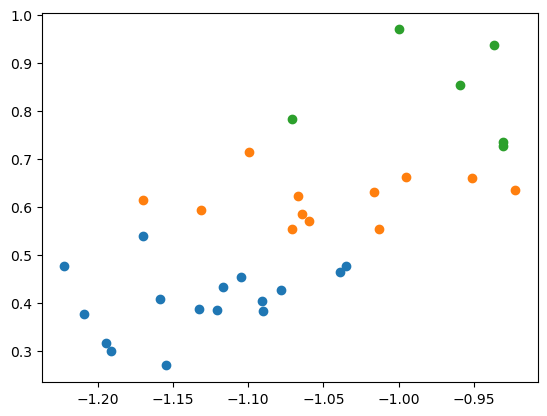

In [8]:
for i in df["cluster_id"].unique():
    tmp = df.loc[df["cluster_id"]==i]
    plt.scatter(tmp[0],tmp[1])